In [1]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import cv2
from keras.api import layers, models, callbacks
import tensorflow as tf
from tensorflow.keras import backend as K

In [2]:
BATCH_SIZE = 100
BUFFER_SIZE = 1000
EMBEDDING_DIM = 2
EPOCHS = 3

In [3]:
x = np.load('../datasets/tp4/pipeline_images.npy')

In [4]:
x.shape

(1112, 228, 308, 3)

In [5]:
def preprocess(imgs):
    gray_images = np.array([cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in imgs])
    gray_images = gray_images.astype('float32') / 255.0
    gray_images = np.pad(gray_images, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    gray_images = np.expand_dims(gray_images, -1)

    return gray_images

In [6]:
x = preprocess(x)

In [7]:
x_train = x[:int(0.8*x.shape[0])]
x_test =  x[int(0.8*x.shape[0]):]
del x

In [8]:
print(x_test.shape)

(223, 232, 312, 1)


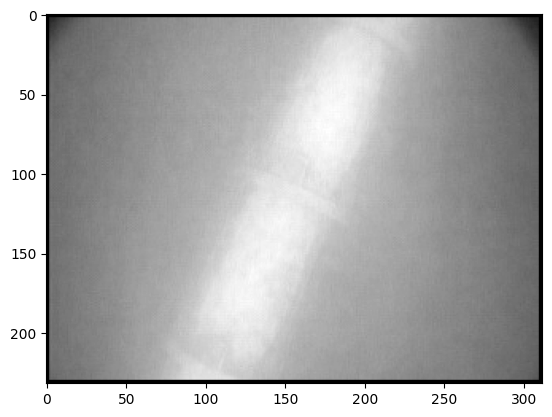

In [9]:
plt.imshow(x_test[100], cmap='gray')

In [10]:
# Encoder
encoder_input = layers.Input(
    shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 232, 312, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 116, 156, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 39, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │       289,538 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,210 (1.46 MB)

 Trainable params: 382,210 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
shape_after_flattening = K.int_shape(decoder_output)[1:]
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 144768)         │       434,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 29, 39, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 58, 78, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 116, 156, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 232, 312, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 232, 312, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 674,433 (2.57 MB)

 Trainable params: 674,433 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 232, 312, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 116, 156, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 29, 39, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144768)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │       289,538 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 232, 312, 1)    │       674,433 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,056,643 (4.03 MB)

 Trainable params: 1,056,643 (4.03 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
print(shape_after_flattening)

(232, 312, 1)


In [14]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [15]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [16]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 5s/step - loss: 0.6919 - val_loss: 0.6828
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - loss: 0.6725 - val_loss: 0.6519
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - loss: 0.6545 - val_loss: 0.6415


In [35]:
n_to_predict = 200
imgs_to_pred = x_test[:n_to_predict]

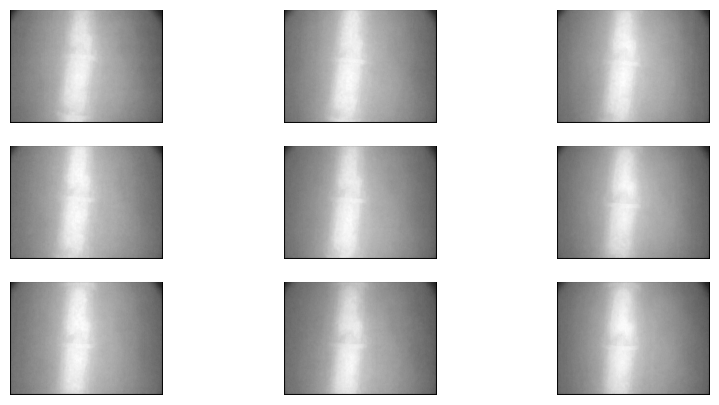

In [63]:
plt.figure(figsize=(10, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs_to_pred[i], cmap='gray'), plt.axis('off')

In [42]:
imgs_reco = autoencoder.predict(imgs_to_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step


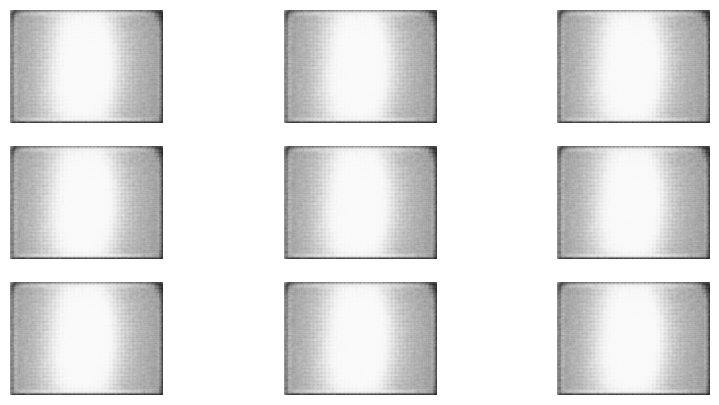

In [64]:
plt.figure(figsize=(10,5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(imgs_reco[i], cmap='gray'), plt.axis('off')

In [48]:
embeddings = encoder.predict(imgs_to_pred)
print(embeddings.shape)
print(embeddings)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
(200, 2)
[[-46.443436 -19.180956]
 [-46.462086 -19.17978 ]
 [-46.585796 -19.247238]
 [-45.74483  -18.89037 ]
 [-46.062424 -19.033201]
 [-47.290913 -19.544569]
 [-45.307636 -18.716892]
 [-45.615906 -18.854841]
 [-47.193893 -19.513504]
 [-45.588352 -18.823473]
 [-45.96834  -18.996336]
 [-46.907036 -19.391258]
 [-46.342857 -19.12363 ]
 [-46.41972  -19.176031]
 [-46.44126  -19.178741]
 [-45.70556  -18.85428 ]
 [-45.996693 -18.984186]
 [-46.814415 -19.32959 ]
 [-46.028214 -18.999712]
 [-46.238323 -19.079636]
 [-47.05327  -19.416418]
 [-46.80608  -19.314375]
 [-46.273197 -19.087118]
 [-47.233025 -19.51225 ]
 [-46.81198  -19.299458]
 [-46.40377  -19.148811]
 [-46.763523 -19.285915]
 [-46.56034  -19.21033 ]
 [-46.769875 -19.299738]
 [-46.959385 -19.377495]
 [-46.914497 -19.330742]
 [-46.820892 -19.32261 ]
 [-46.92324  -19.349504]
 [-46.96466  -19.39711 ]
 [-46.439907 -19.150045]
 [-47.18182  -19.485054]
 [-47.09531  -19.421825]
 [-46.730923 -19.282764]
 [-

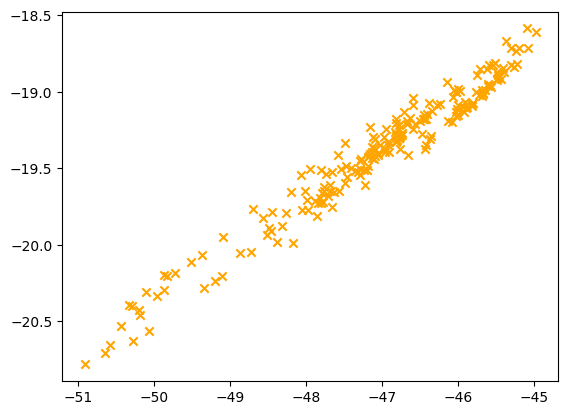

In [52]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker='x', color='orange')

In [53]:
# Get the range of the existing embeddings
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

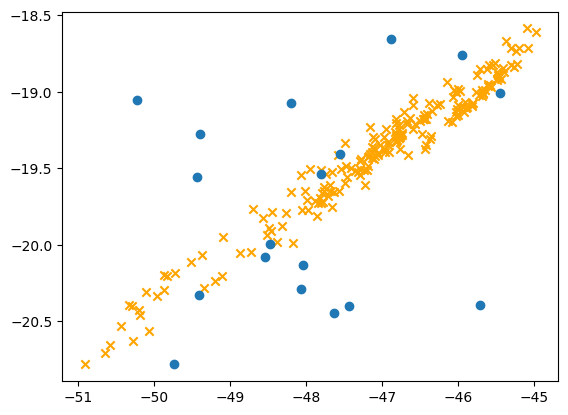

In [60]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], marker='x', color='orange')
plt.scatter(sample[:, 0], sample[:, 1])

In [68]:
generation = decoder.predict(sample)
print(generation.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
(18, 232, 312, 1)


(<matplotlib.image.AxesImage at 0x1bccda91e80>, (-0.5, 311.5, 231.5, -0.5))

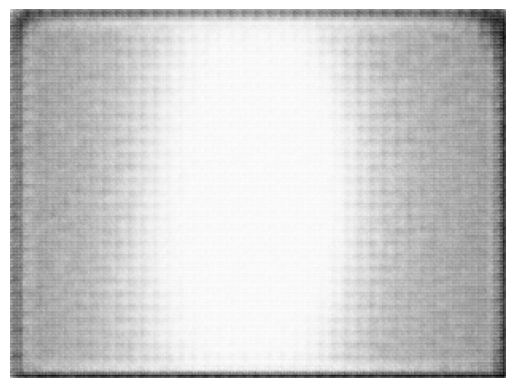

In [73]:

plt.imshow(generation[10], cmap='gray'), plt.axis('off')